In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:
import random

dynamic_1 = np.where(trainy == 0)[0]
dynamic_2 = np.where(trainy == 1)[0]
dynamic_3 = np.where(trainy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic)

trainX = X_train_all[dynamic]
trainy = y_train_all[dynamic]

<ipython-input-9-c62d2340b2f3>:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [10]:
dynamic_1 = np.where(testy == 0)[0]
dynamic_2 = np.where(testy == 1)[0]
dynamic_3 = np.where(testy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic_list)

testX = X_test_all[dynamic]
testy = y_test_all[dynamic]

<ipython-input-10-7edbb04a2a02>:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [11]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]]


In [12]:

trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [13]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (3285, 128, 9)
Y train shape:  (3285, 1)
Y train One hot shape:  (3285, 3)
X test shape:  (1387, 128, 9)
Y test shape:  (1387, 1)
Y test One hot shape:  (1387, 3)


In [14]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [15]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

# LSTM1

In [16]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 128)          70656     
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 126, 64)           24640     
                                                                 
 dropout_1 (Dropout)         (None, 126, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 63, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4032)              0         
                                                        

In [17]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 11s 97ms/step - loss: 0.8680 - accuracy: 0.5851 - val_loss: 0.5812 - val_accuracy: 0.7901
Epoch 2/10
26/26 [==============================] - 1s 35ms/step - loss: 0.4053 - accuracy: 0.8673 - val_loss: 0.2261 - val_accuracy: 0.9513
Epoch 3/10
26/26 [==============================] - 1s 28ms/step - loss: 0.1395 - accuracy: 0.9592 - val_loss: 0.0652 - val_accuracy: 0.9848
Epoch 4/10
26/26 [==============================] - 1s 21ms/step - loss: 0.0468 - accuracy: 0.9857 - val_loss: 0.0356 - val_accuracy: 0.9970
Epoch 5/10
26/26 [==============================] - 0s 19ms/step - loss: 0.0202 - accuracy: 0.9927 - val_loss: 0.0198 - val_accuracy: 0.9980
Epoch 6/10
26/26 [==============================] - 0s 17ms/step - loss: 0.0103 - accuracy: 0.9954 - val_loss: 0.0089 - val_accuracy: 0.9990
Epoch 7/10
26/26 [==============================] - 1s 24ms/step - loss: 0.0076 - accuracy: 0.9973 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 8/10
2

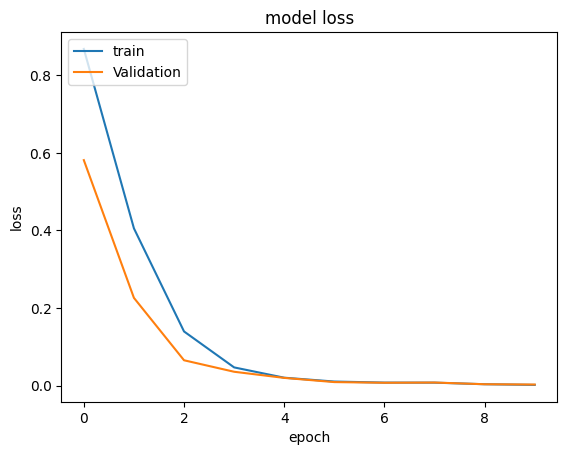

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

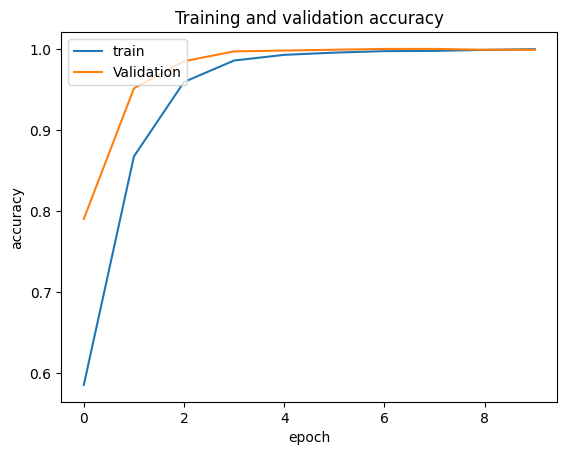

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 2s 10ms/step
[[467  21   8]
 [ 18 451   2]
 [  0   0 420]]
0.9646719538572458
0.9645400548190011
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       496
           1       0.96      0.96      0.96       471
           2       0.98      1.00      0.99       420

    accuracy                           0.96      1387
   macro avg       0.97      0.97      0.97      1387
weighted avg       0.96      0.96      0.96      1387



<Axes: >

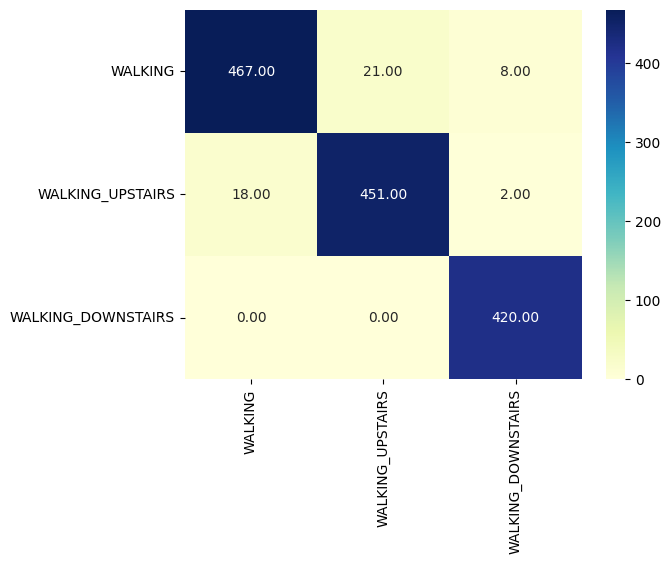

In [20]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM1 - CNN2


In [21]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_2 (Dropout)         (None, 128, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 126, 64)           24640     
                                                                 
 conv1d_2 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 dropout_3 (Dropout)         (None, 124, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 62, 64)            0         
 g1D)                                                            
                                                      

In [22]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 5s 56ms/step - loss: 0.8967 - accuracy: 0.5702 - val_loss: 0.6462 - val_accuracy: 0.7718
Epoch 2/10
26/26 [==============================] - 0s 15ms/step - loss: 0.3614 - accuracy: 0.8712 - val_loss: 0.1482 - val_accuracy: 0.9584
Epoch 3/10
26/26 [==============================] - 0s 14ms/step - loss: 0.0825 - accuracy: 0.9702 - val_loss: 0.0343 - val_accuracy: 0.9959
Epoch 4/10
26/26 [==============================] - 0s 15ms/step - loss: 0.0186 - accuracy: 0.9954 - val_loss: 0.0144 - val_accuracy: 0.9980
Epoch 5/10
26/26 [==============================] - 1s 24ms/step - loss: 0.0071 - accuracy: 0.9973 - val_loss: 0.0445 - val_accuracy: 0.9828
Epoch 6/10
26/26 [==============================] - 1s 21ms/step - loss: 0.0171 - accuracy: 0.9948 - val_loss: 0.0153 - val_accuracy: 0.9949
Epoch 7/10
26/26 [==============================] - 1s 25ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 8/10
26

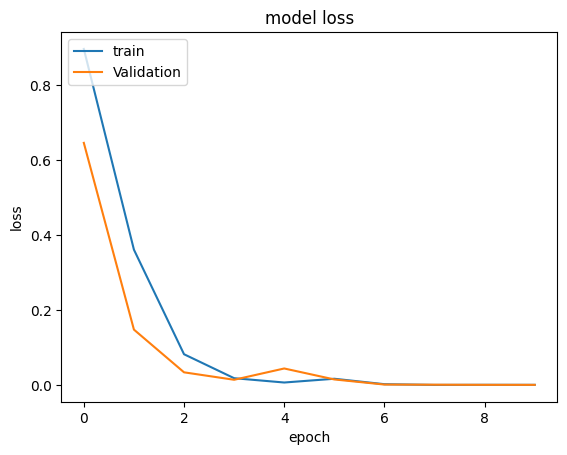

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

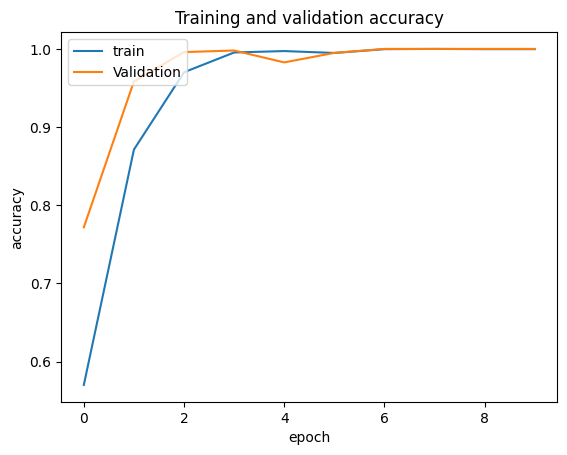

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 2s 7ms/step
[[468   1  27]
 [  9 438  24]
 [  1   0 419]]
0.9552992069214131
0.9556681633713422
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       496
           1       1.00      0.93      0.96       471
           2       0.89      1.00      0.94       420

    accuracy                           0.96      1387
   macro avg       0.96      0.96      0.96      1387
weighted avg       0.96      0.96      0.96      1387



<Axes: >

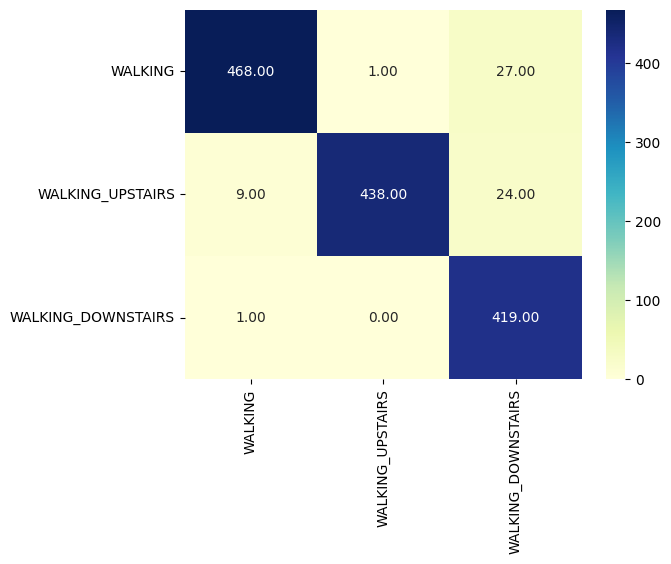

In [25]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# # LSTM2 - CNN1

In [36]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
# RNN layer
model.add(LSTM(units = 128, return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_10 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_8 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_11 (Dropout)        (None, 128, 128)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 126, 64)           24640     
                                                                 
 dropout_12 (Dropout)        (None, 126, 64)           0         
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 63, 64)           

In [37]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 6s 102ms/step - loss: 0.9330 - accuracy: 0.5087 - val_loss: 0.6582 - val_accuracy: 0.7475
Epoch 2/10
26/26 [==============================] - 1s 52ms/step - loss: 0.4118 - accuracy: 0.8438 - val_loss: 0.2911 - val_accuracy: 0.9270
Epoch 3/10
26/26 [==============================] - 1s 39ms/step - loss: 0.1530 - accuracy: 0.9513 - val_loss: 0.0568 - val_accuracy: 0.9899
Epoch 4/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0544 - accuracy: 0.9823 - val_loss: 0.0416 - val_accuracy: 0.9929
Epoch 5/10
26/26 [==============================] - 1s 43ms/step - loss: 0.0174 - accuracy: 0.9945 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 6/10
26/26 [==============================] - 1s 25ms/step - loss: 0.0118 - accuracy: 0.9954 - val_loss: 0.0256 - val_accuracy: 0.9909
Epoch 7/10
26/26 [==============================] - 1s 26ms/step - loss: 0.0243 - accuracy: 0.9906 - val_loss: 0.0331 - val_accuracy: 0.9939
Epoch 8/10
2

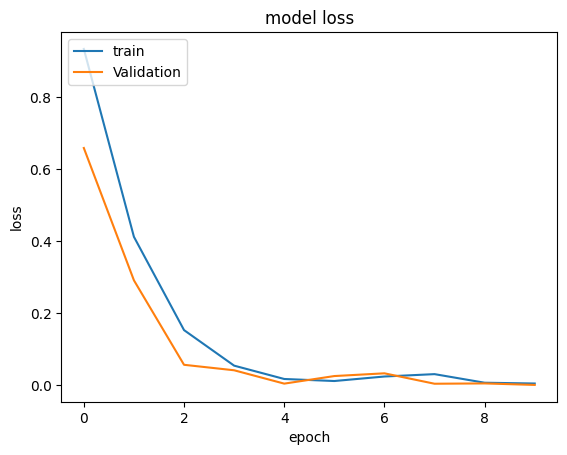

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

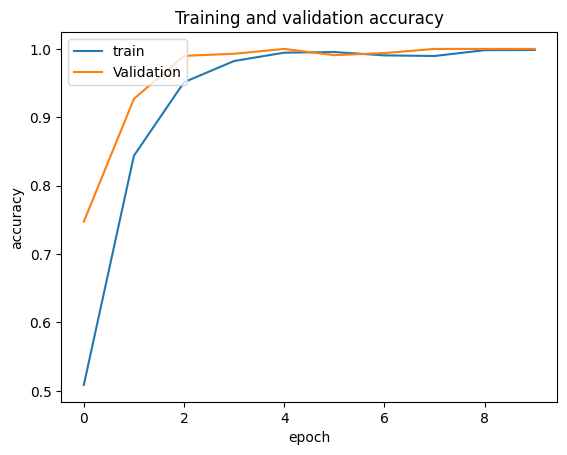

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 5ms/step
[[445  24  27]
 [ 12 430  29]
 [  0   0 420]]
0.9336697909156453
0.9335714604248835
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       496
           1       0.95      0.91      0.93       471
           2       0.88      1.00      0.94       420

    accuracy                           0.93      1387
   macro avg       0.93      0.94      0.93      1387
weighted avg       0.94      0.93      0.93      1387



<Axes: >

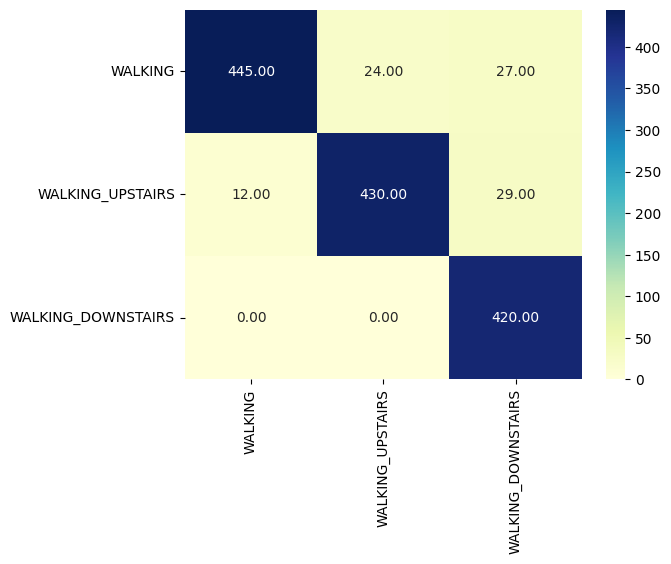

In [40]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM2 - CNN2

In [31]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
# RNN layer
model.add(LSTM(units = 128, return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_7 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_6 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_8 (Dropout)         (None, 128, 128)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 126, 64)           24640     
                                                                 
 conv1d_4 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 dropout_9 (Dropout)         (None, 124, 64)          

In [32]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 7s 74ms/step - loss: 0.9079 - accuracy: 0.5699 - val_loss: 0.6475 - val_accuracy: 0.7637
Epoch 2/10
26/26 [==============================] - 1s 28ms/step - loss: 0.5096 - accuracy: 0.8180 - val_loss: 0.3351 - val_accuracy: 0.9087
Epoch 3/10
26/26 [==============================] - 1s 28ms/step - loss: 0.2237 - accuracy: 0.9224 - val_loss: 0.0816 - val_accuracy: 0.9878
Epoch 4/10
26/26 [==============================] - 1s 25ms/step - loss: 0.0607 - accuracy: 0.9808 - val_loss: 0.0260 - val_accuracy: 0.9959
Epoch 5/10
26/26 [==============================] - 1s 28ms/step - loss: 0.0182 - accuracy: 0.9942 - val_loss: 0.0123 - val_accuracy: 0.9970
Epoch 6/10
26/26 [==============================] - 1s 24ms/step - loss: 0.0180 - accuracy: 0.9939 - val_loss: 0.0097 - val_accuracy: 0.9990
Epoch 7/10
26/26 [==============================] - 1s 23ms/step - loss: 0.0165 - accuracy: 0.9951 - val_loss: 0.0209 - val_accuracy: 0.9939
Epoch 8/10
26

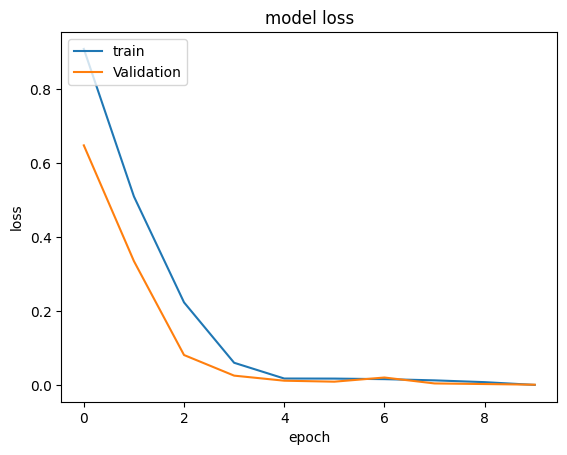

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

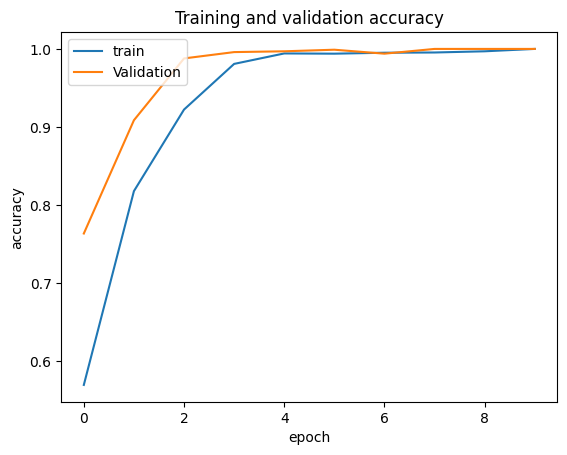

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 5ms/step
[[466   3  27]
 [  6 439  26]
 [  0   1 419]]
0.9545782263878875
0.954993718615847
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       496
           1       0.99      0.93      0.96       471
           2       0.89      1.00      0.94       420

    accuracy                           0.95      1387
   macro avg       0.96      0.96      0.95      1387
weighted avg       0.96      0.95      0.95      1387



<Axes: >

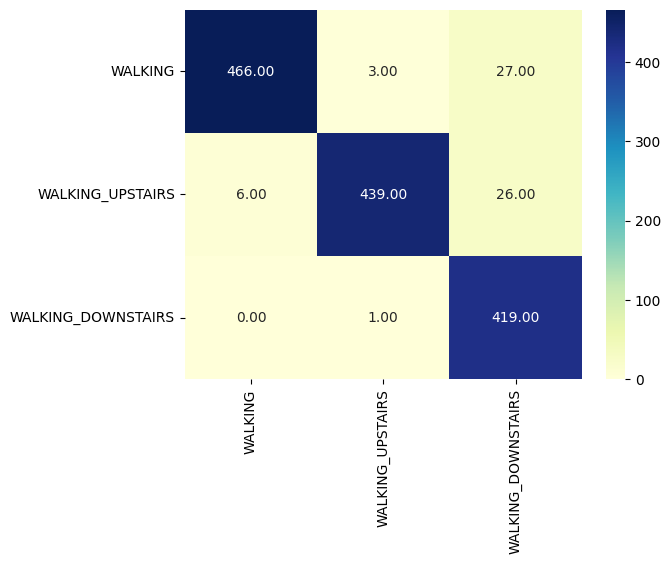

In [35]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')